In [1]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/mhealth/study/test_submission/'
import os
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/mhealth/study/test_submission'

In [6]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 12.8 MB/s eta 0:00:00


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
# Fix for the missing find_peaks import
from scipy.signal import find_peaks, medfilt

# Set the base directory
base_dir = "/content/drive/MyDrive/mhealth/study/test_submission"
print(f"Using data from: {base_dir}")

# Create ECG/HRV directory if needed
for participant in ['p1', 'p2']:
    ecg_dir = os.path.join(base_dir, participant, 'ecg_hrv')
    if not os.path.exists(ecg_dir):
        os.makedirs(ecg_dir)
        print(f"Created directory: {ecg_dir}")

# Cell 2: Load ECG data function
def load_participant_data(participant_id):
    """Load merged sensor data for a participant"""
    data_file = os.path.join(base_dir, participant_id, 'data', 'merged_sensor_data.csv')
    if os.path.exists(data_file):
        df = pd.read_csv(data_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    else:
        print(f"Error: Data file not found for {participant_id}")
        return None


Using data from: /content/drive/MyDrive/mhealth/study/test_submission


In [8]:
def extract_activity_data(df, participant_id):
    """Extract data segments for each activity type"""
    # Define activity sessions
    if participant_id == 'p1':
        sessions = {
            'resting': {'start': '2025-03-11 23:42:00', 'end': '2025-03-11 23:48:00', 'color': 'green'},
            'boring': {'start': '2025-03-11 23:50:00', 'end': '2025-03-11 23:55:00', 'color': 'orange'},
            'exciting': {'start': '2025-03-11 23:57:00', 'end': '2025-03-12 00:02:00', 'color': 'red'}
        }
    else:  # p2
        sessions = {
            'resting': {'start': '2025-03-12 00:15:29', 'end': '2025-03-12 00:20:29', 'color': 'green'},
            'boring': {'start': '2025-03-12 00:21:00', 'end': '2025-03-12 00:26:00', 'color': 'orange'},
            'exciting': {'start': '2025-03-12 00:26:50', 'end': '2025-03-12 00:31:50', 'color': 'red'}
        }

    activity_data = {}
    for activity_type, session in sessions.items():
        start_time = pd.to_datetime(session['start'])
        end_time = pd.to_datetime(session['end'])

        # Filter data for this activity
        activity_segment = df[(df['timestamp'] >= start_time) &
                             (df['timestamp'] <= end_time)].copy()

        # Add activity type and color as columns
        activity_segment['activity_type'] = activity_type
        activity_segment['color'] = session.get('color', 'blue')
        activity_data[activity_type] = activity_segment

    return activity_data, sessions

In [9]:
participant_data = {}
activity_data = {}

for participant in ['p1', 'p2']:
    df = load_participant_data(participant)
    if df is not None:
        participant_data[participant] = df
        activity_data[participant], _ = extract_activity_data(df, participant)
        print(f"Loaded data for {participant}: {len(df)} rows")


Loaded data for p1: 11472 rows
Loaded data for p2: 10983 rows


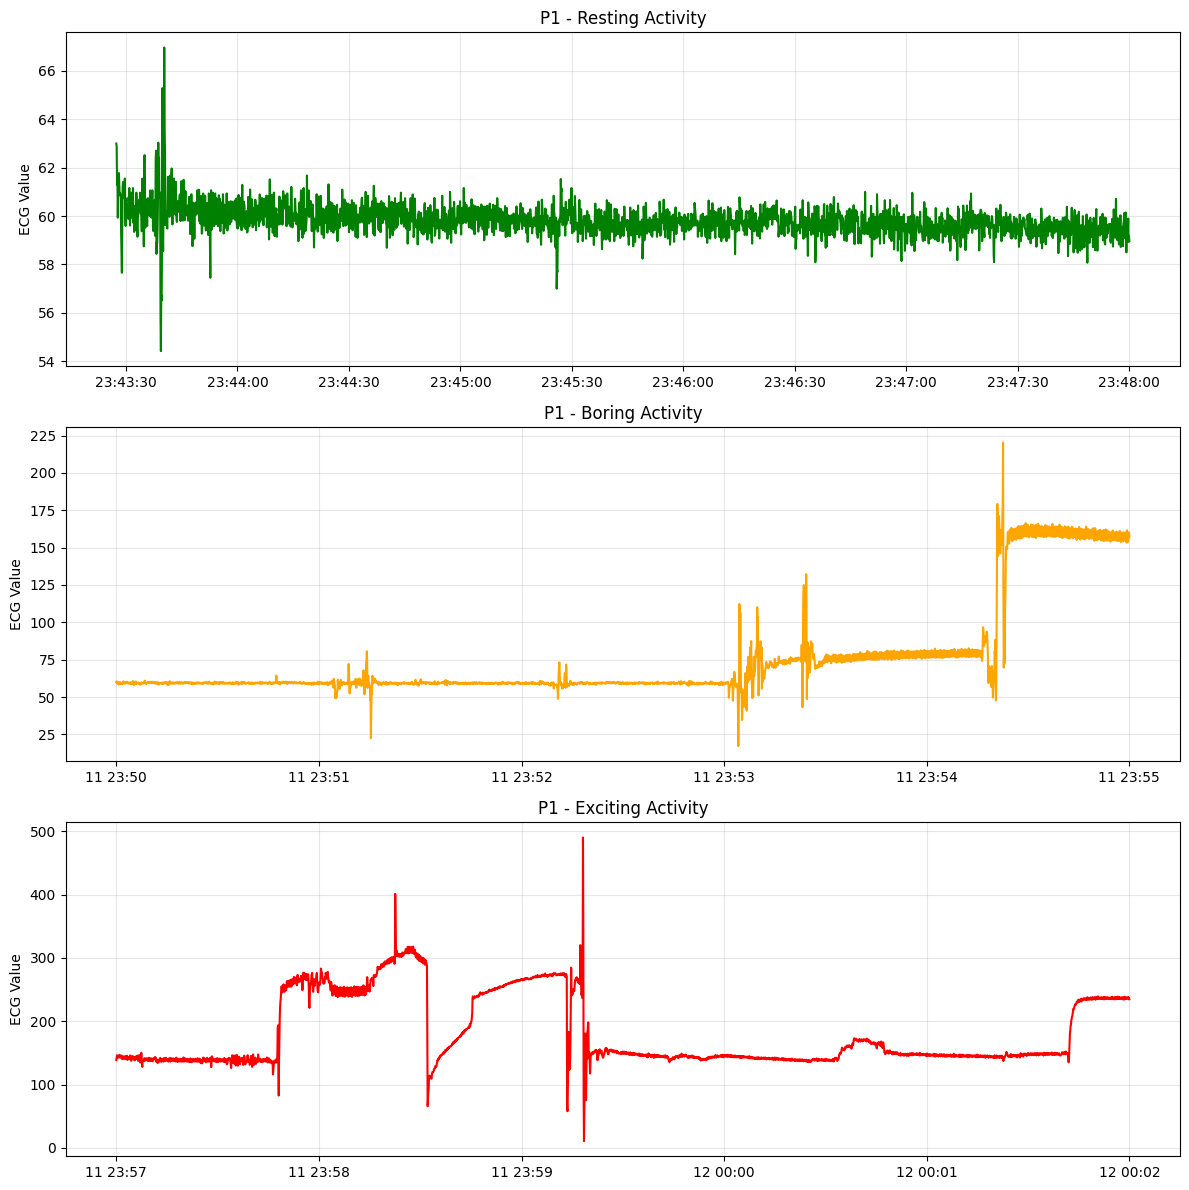

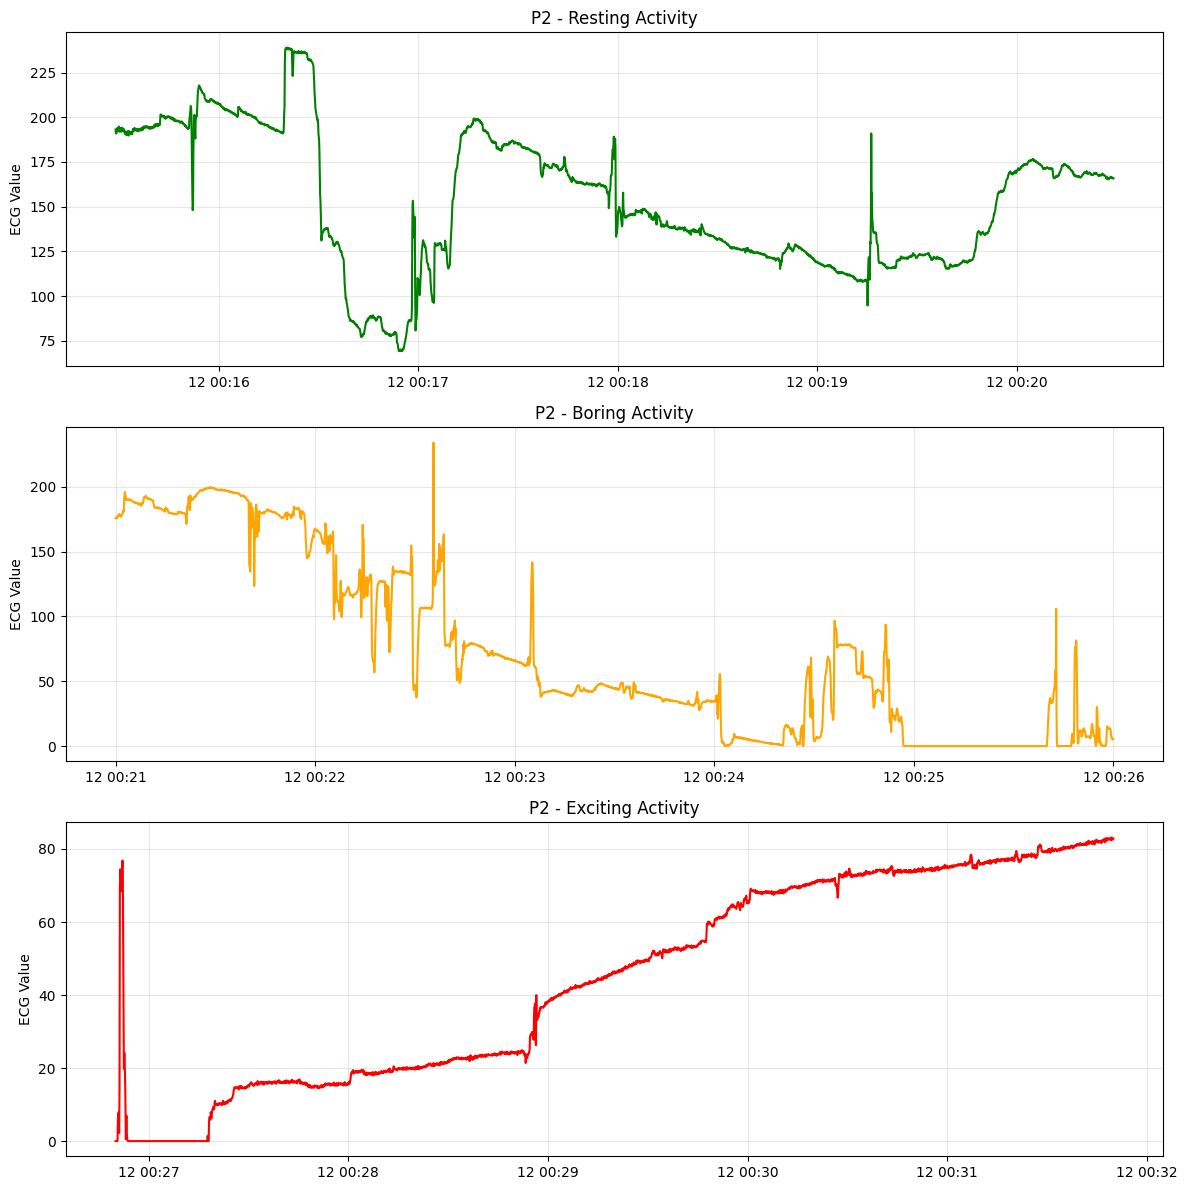

In [10]:
# Visualize raw ECG data for each activity
def plot_raw_ecg(participant_id):
    """Plot raw ECG for each activity"""
    if participant_id not in activity_data:
        print(f"No data available for {participant_id}")
        return

    fig, axes = plt.subplots(len(activity_data[participant_id]), 1,
                            figsize=(12, 4*len(activity_data[participant_id])))

    if len(activity_data[participant_id]) == 1:
        axes = [axes]

    for i, (activity, df) in enumerate(activity_data[participant_id].items()):
        color = df['color'].iloc[0]
        axes[i].plot(df['timestamp'], df['ecg_value'], color=color)
        axes[i].set_title(f"{participant_id.upper()} - {activity.capitalize()} Activity")
        axes[i].set_ylabel('ECG Value')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, participant_id, 'ecg_hrv', 'raw_ecg.png'), dpi=300)
    plt.show()

# Plot raw ECG
for participant in ['p1', 'p2']:
    if participant in activity_data:
        plot_raw_ecg(participant)

p1 - resting sampling rate: 10.00 Hz


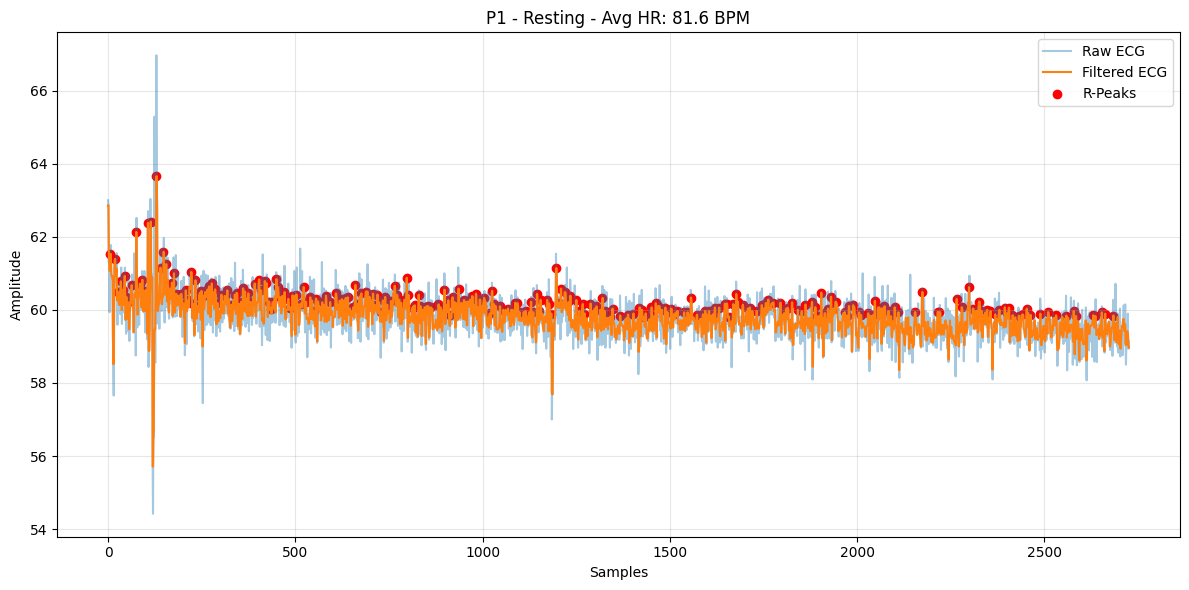

p1 - boring sampling rate: 10.00 Hz


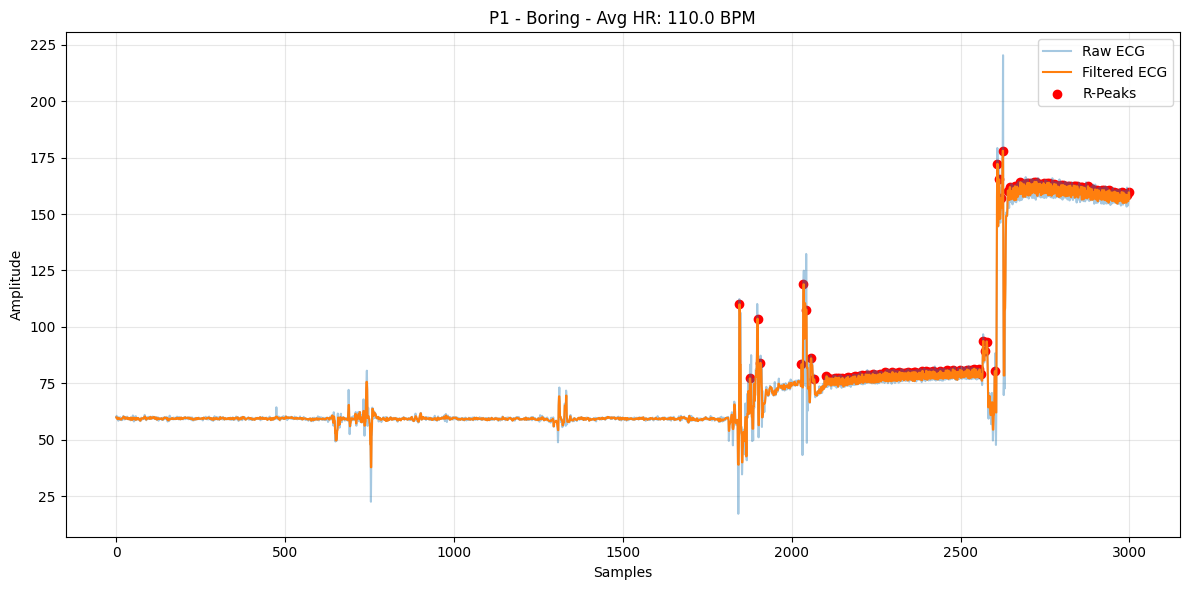

p1 - exciting sampling rate: 10.00 Hz


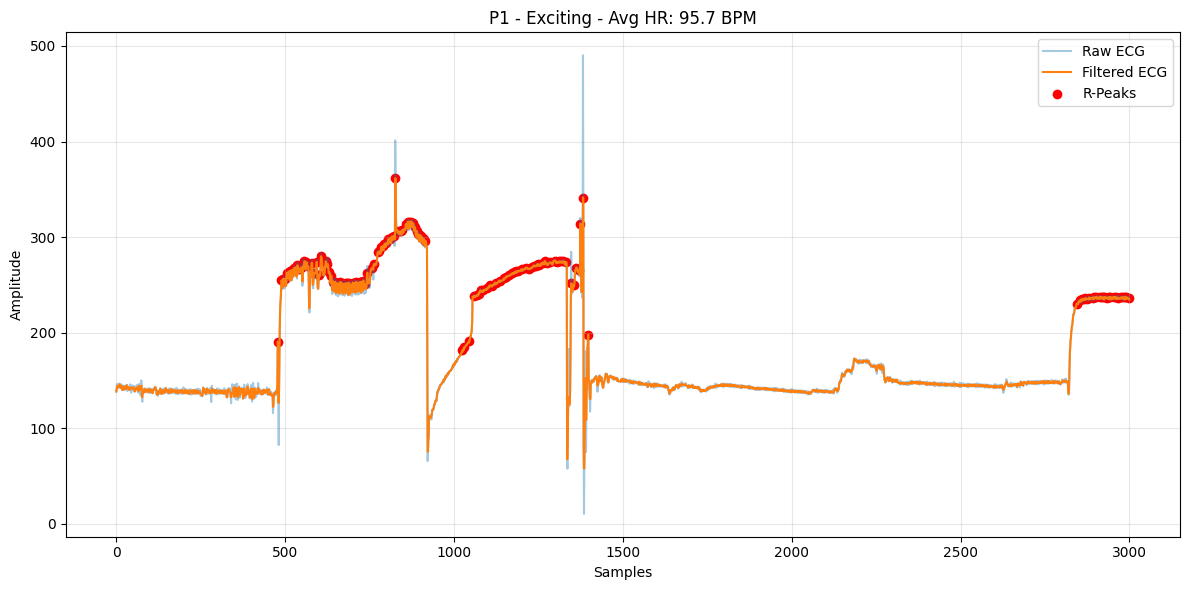

p2 - resting sampling rate: 10.00 Hz


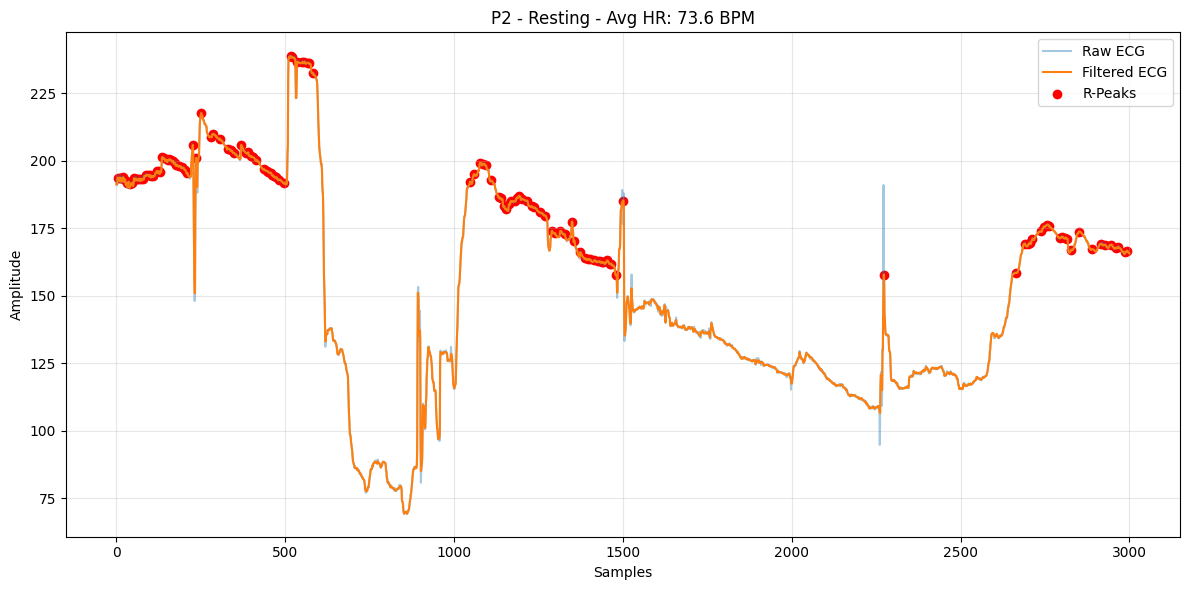

p2 - boring sampling rate: 10.00 Hz


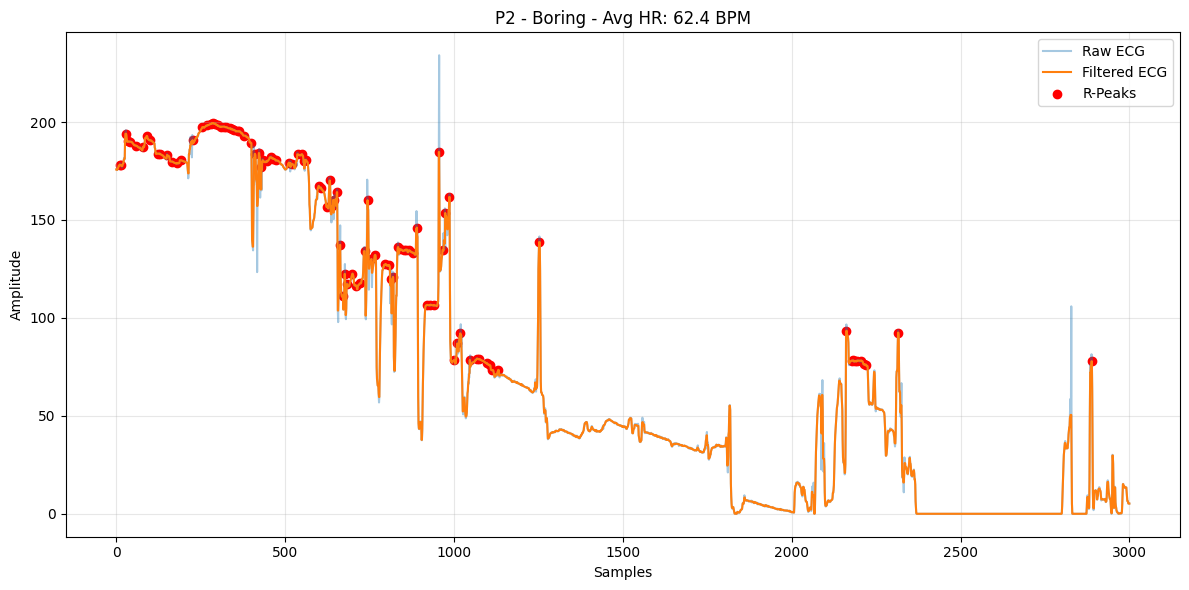

p2 - exciting sampling rate: 10.00 Hz


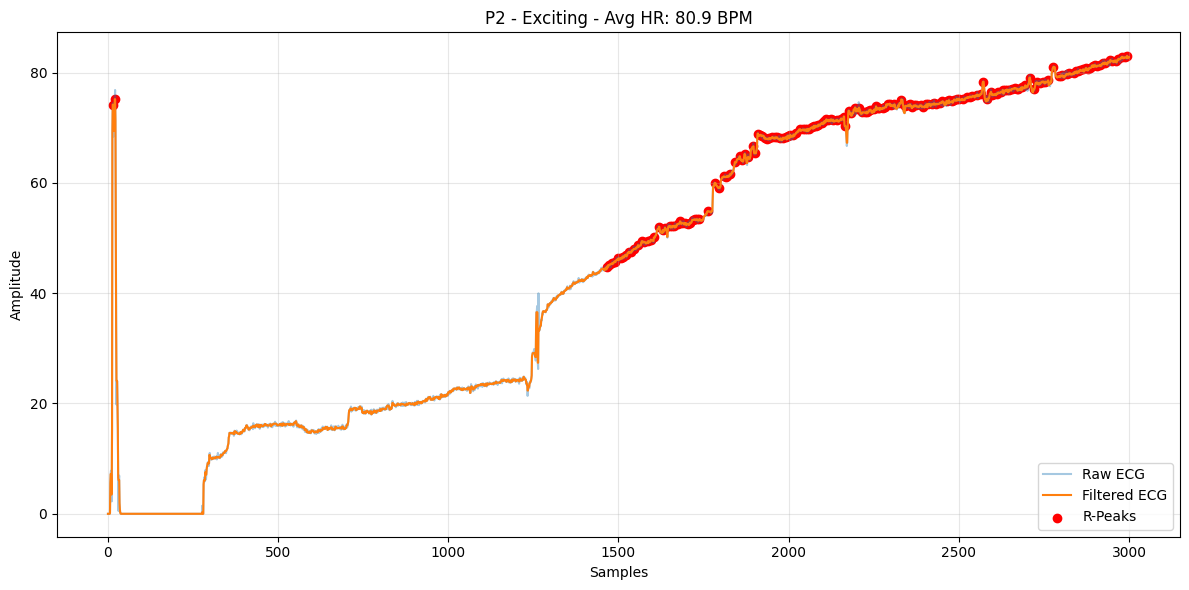

In [14]:
def process_ecg_simple(participant_id):
    """Process ECG signal and detect R-peaks using a simple approach"""
    if participant_id not in activity_data:
        print(f"No data available for {participant_id}")
        return None, None

    processed_ecg = {}
    detected_peaks = {}

    for activity, df in activity_data[participant_id].items():
        # Get ECG data
        ecg_signal = df['ecg_value'].values

        # Handle any NaN or zero values
        ecg_signal = np.nan_to_num(ecg_signal)
        if np.all(ecg_signal == 0):
            print(f"Warning: All zeros in ECG data for {participant_id} - {activity}")
            continue

        # Estimate sampling rate from timestamps
        time_diff = df['timestamp'].diff().dropna()
        sampling_rate = 1 / time_diff.dt.total_seconds().mean()
        print(f"{participant_id} - {activity} sampling rate: {sampling_rate:.2f} Hz")

        try:
            # Simple preprocessing
            # 1. Apply bandpass filter to remove noise
            if sampling_rate > 0:
                # Convert to float to avoid integer division issues
                ecg_signal = ecg_signal.astype(float)

                # Simple moving average filter to smooth the signal
                window_size = int(sampling_rate * 0.1)  # 100ms window
                window_size = max(3, window_size if window_size % 2 == 1 else window_size + 1)  # ensure odd window size

                # Apply moving average filter
                ecg_filtered = signal.medfilt(ecg_signal, window_size)

                # Find peaks (R peaks) in ECG signal
                # Adjust these parameters as needed for your specific data
                peak_indices, _ = find_peaks(ecg_filtered,
                                            distance=int(sampling_rate * 0.5),  # minimum distance between peaks
                                            height=np.mean(ecg_filtered))      # minimum height of peaks

                # Store processed data
                processed_ecg[activity] = ecg_filtered
                detected_peaks[activity] = peak_indices

                # Plot processed ECG with peaks for visualization
                plt.figure(figsize=(12, 6))
                plt.plot(ecg_signal, label='Raw ECG', alpha=0.4)
                plt.plot(ecg_filtered, label='Filtered ECG')

                # Plot detected R-peaks
                if len(peak_indices) > 0:
                    plt.scatter(peak_indices, ecg_filtered[peak_indices],
                              color='red', marker='o', label='R-Peaks')

                # Calculate heart rate
                if len(peak_indices) > 1:
                    # Convert to seconds and then to BPM
                    rr_intervals = np.diff(peak_indices) / sampling_rate
                    heart_rates = 60 / rr_intervals  # in BPM
                    avg_hr = np.mean(heart_rates)

                    plt.title(f"{participant_id.upper()} - {activity.capitalize()} - Avg HR: {avg_hr:.1f} BPM")
                else:
                    plt.title(f"{participant_id.upper()} - {activity.capitalize()} - No HR available")

                plt.xlabel('Samples')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig(os.path.join(base_dir, participant_id, 'ecg_hrv', f'{activity}_processed_ecg.png'), dpi=300)
                plt.show()
            else:
                print(f"Error: Invalid sampling rate for {participant_id} - {activity}")

        except Exception as e:
            print(f"Error processing {participant_id} - {activity}: {str(e)}")

    return processed_ecg, detected_peaks

# Process ECG for both participants
processed_signals = {}
peak_indices = {}

for participant in ['p1', 'p2']:
    if participant in activity_data:
        processed_signals[participant], peak_indices[participant] = process_ecg_simple(participant)

In [15]:
def calculate_heart_rate_stats(participant_id):
    """Calculate basic heart rate statistics for each activity"""
    if participant_id not in peak_indices or peak_indices[participant_id] is None:
        print(f"No peak data available for {participant_id}")
        return None

    hr_stats = {}

    for activity, peaks in peak_indices[participant_id].items():
        if len(peaks) < 2:
            print(f"Not enough peaks to calculate HR for {participant_id} - {activity}")
            continue

        # Get sampling rate
        df = activity_data[participant_id][activity]
        time_diff = df['timestamp'].diff().dropna()
        sampling_rate = 1 / time_diff.dt.total_seconds().mean()

        if sampling_rate <= 0:
            print(f"Invalid sampling rate for {participant_id} - {activity}")
            continue

        try:
            # Calculate RR intervals in seconds
            rr_intervals = np.diff(peaks) / sampling_rate

            # Calculate heart rate in BPM
            heart_rates = 60 / rr_intervals

            # Calculate basic statistics
            hr_stats[activity] = {
                'mean_hr': np.mean(heart_rates),
                'std_hr': np.std(heart_rates),
                'min_hr': np.min(heart_rates),
                'max_hr': np.max(heart_rates),
                'median_hr': np.median(heart_rates),
                'rr_intervals': rr_intervals,
                'heart_rates': heart_rates
            }

            # Print summary
            print(f"\n{participant_id.upper()} - {activity.capitalize()} Activity - Heart Rate:")
            print(f"Mean HR: {hr_stats[activity]['mean_hr']:.2f} BPM")
            print(f"Std Dev HR: {hr_stats[activity]['std_hr']:.2f} BPM")
            print(f"Range HR: {hr_stats[activity]['min_hr']:.2f} - {hr_stats[activity]['max_hr']:.2f} BPM")

        except Exception as e:
            print(f"Error calculating HR stats for {participant_id} - {activity}: {str(e)}")

    return hr_stats

# Calculate heart rate stats for both participants
hr_statistics = {}
for participant in ['p1', 'p2']:
    if participant in peak_indices:
        hr_statistics[participant] = calculate_heart_rate_stats(participant)



P1 - Resting Activity - Heart Rate:
Mean HR: 81.60 BPM
Std Dev HR: 31.45 BPM
Range HR: 12.77 - 120.00 BPM

P1 - Boring Activity - Heart Rate:
Mean HR: 110.03 BPM
Std Dev HR: 20.54 BPM
Range HR: 4.92 - 120.00 BPM

P1 - Exciting Activity - Heart Rate:
Mean HR: 95.66 BPM
Std Dev HR: 28.25 BPM
Range HR: 0.41 - 120.00 BPM

P2 - Resting Activity - Heart Rate:
Mean HR: 73.61 BPM
Std Dev HR: 35.62 BPM
Range HR: 0.78 - 120.00 BPM

P2 - Boring Activity - Heart Rate:
Mean HR: 62.40 BPM
Std Dev HR: 31.08 BPM
Range HR: 0.66 - 120.00 BPM

P2 - Exciting Activity - Heart Rate:
Mean HR: 80.91 BPM
Std Dev HR: 27.25 BPM
Range HR: 0.41 - 120.00 BPM


In [16]:
def calculate_simple_hrv(participant_id):
    """Calculate simple HRV metrics from RR intervals"""
    if participant_id not in hr_statistics or hr_statistics[participant_id] is None:
        print(f"No heart rate statistics available for {participant_id}")
        return None

    hrv_stats = {}

    for activity, stats in hr_statistics[participant_id].items():
        if 'rr_intervals' not in stats or len(stats['rr_intervals']) < 2:
            print(f"Not enough RR intervals for {participant_id} - {activity}")
            continue

        try:
            # Get RR intervals in milliseconds
            rr_intervals_ms = stats['rr_intervals'] * 1000

            # Calculate basic time domain HRV metrics
            hrv_stats[activity] = {
                # SDNN - Standard deviation of NN (normal-to-normal) intervals
                'SDNN': np.std(rr_intervals_ms),

                # RMSSD - Root mean square of successive differences
                'RMSSD': np.sqrt(np.mean(np.diff(rr_intervals_ms) ** 2)),

                # pNN50 - Percentage of successive RR intervals that differ by more than 50 ms
                'pNN50': 100 * np.sum(np.abs(np.diff(rr_intervals_ms)) > 50) / len(rr_intervals_ms),

                # Mean RR interval
                'MeanRR': np.mean(rr_intervals_ms)
            }

            # Print summary
            print(f"\n{participant_id.upper()} - {activity.capitalize()} Activity - HRV Metrics:")
            print(f"SDNN: {hrv_stats[activity]['SDNN']:.2f} ms")
            print(f"RMSSD: {hrv_stats[activity]['RMSSD']:.2f} ms")
            print(f"pNN50: {hrv_stats[activity]['pNN50']:.2f}%")
            print(f"Mean RR: {hrv_stats[activity]['MeanRR']:.2f} ms")

        except Exception as e:
            print(f"Error calculating HRV for {participant_id} - {activity}: {str(e)}")

    return hrv_stats

# Calculate simple HRV metrics for both participants
hrv_metrics = {}
for participant in ['p1', 'p2']:
    if participant in hr_statistics:
        hrv_metrics[participant] = calculate_simple_hrv(participant)


P1 - Resting Activity - HRV Metrics:
SDNN: 603.95 ms
RMSSD: 788.89 ms
pNN50: 83.45%
Mean RR: 923.45 ms

P1 - Boring Activity - HRV Metrics:
SDNN: 958.58 ms
RMSSD: 1312.02 ms
pNN50: 57.23%
Mean RR: 666.47 ms

P1 - Exciting Activity - HRV Metrics:
SDNN: 12070.25 ms
RMSSD: 17133.04 ms
pNN50: 76.76%
Mean RR: 1774.65 ms

P2 - Resting Activity - HRV Metrics:
SDNN: 8367.24 ms
RMSSD: 9863.00 ms
pNN50: 87.79%
Mean RR: 2280.92 ms

P2 - Boring Activity - HRV Metrics:
SDNN: 10471.26 ms
RMSSD: 12891.14 ms
pNN50: 94.12%
Mean RR: 2821.57 ms

P2 - Exciting Activity - HRV Metrics:
SDNN: 10574.67 ms
RMSSD: 15066.15 ms
pNN50: 88.59%
Mean RR: 1619.57 ms


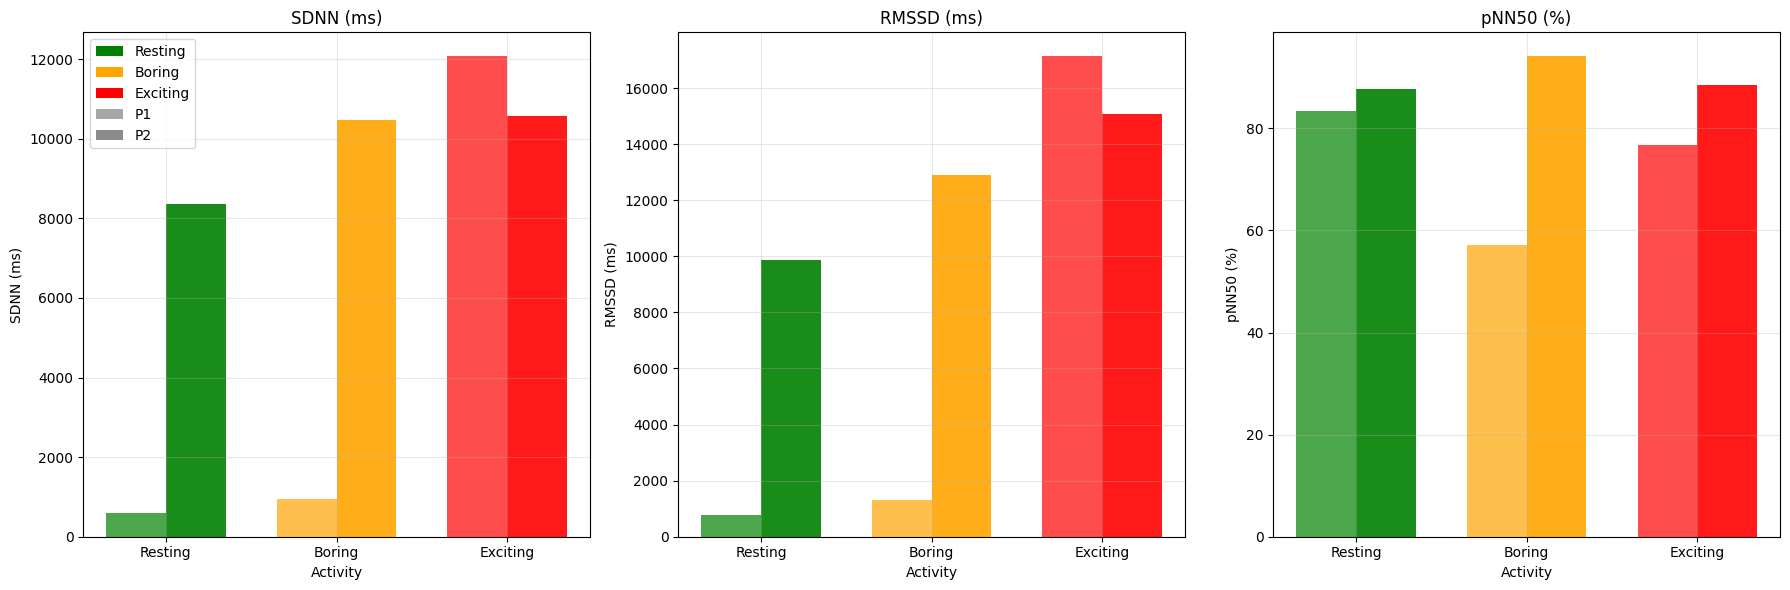

In [18]:
def visualize_hrv_comparison():
    """Create visualization comparing key HRV metrics between activities and participants"""
    # Check if HRV metrics are available
    if not hrv_metrics or not all(p in hrv_metrics for p in ['p1', 'p2']):
        print("Not enough HRV data available for comparison")
        return

    # Select key metrics to visualize
    key_metrics = ['SDNN', 'RMSSD', 'pNN50']
    metric_labels = {
        'SDNN': 'SDNN (ms)',
        'RMSSD': 'RMSSD (ms)',
        'pNN50': 'pNN50 (%)'
    }

    # Create a figure with 3 subplots (one for each metric)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Activity names and colors
    activities = ['resting', 'boring', 'exciting']
    activity_colors = {
        'resting': 'green',
        'boring': 'orange',
        'exciting': 'red'
    }

    # Width of bars
    width = 0.35

    for i, metric in enumerate(key_metrics):
        # X positions for bars
        x = np.arange(len(activities))

        # Extract metric values for each participant and activity
        p1_values = []
        p2_values = []

        for activity in activities:
            try:
                if activity in hrv_metrics.get('p1', {}):
                    p1_values.append(hrv_metrics['p1'][activity][metric])
                else:
                    p1_values.append(np.nan)

                if activity in hrv_metrics.get('p2', {}):
                    p2_values.append(hrv_metrics['p2'][activity][metric])
                else:
                    p2_values.append(np.nan)
            except:
                p1_values.append(np.nan)
                p2_values.append(np.nan)

        # Create bars with appropriate colors for each activity
        for j, activity in enumerate(activities):
            # P1 bars (slightly lighter shade)
            if j < len(p1_values) and not np.isnan(p1_values[j]):
                color = activity_colors[activity]
                # Make a slightly lighter version for P1
                axes[i].bar(x[j] - width/2, p1_values[j], width,
                          color=color, alpha=0.7, label=f'P1 {activity.capitalize()}' if i == 0 and j == 0 else "")

            # P2 bars (slightly darker shade)
            if j < len(p2_values) and not np.isnan(p2_values[j]):
                color = activity_colors[activity]
                # Make a slightly darker version for P2
                axes[i].bar(x[j] + width/2, p2_values[j], width,
                          color=color, alpha=0.9, label=f'P2 {activity.capitalize()}' if i == 0 and j == 0 else "")

        # Add labels and title
        axes[i].set_xlabel('Activity')
        axes[i].set_ylabel(metric_labels[metric])
        axes[i].set_title(metric_labels[metric])
        axes[i].set_xticks(x)
        axes[i].set_xticklabels([a.capitalize() for a in activities])

        # Add custom legend
        if i == 0:
            # Create custom legend handles
            from matplotlib.patches import Patch
            legend_elements = []

            # Add activity colors
            for activity, color in activity_colors.items():
                legend_elements.append(Patch(facecolor=color, label=activity.capitalize()))

            # Add participant indicators
            legend_elements.append(Patch(facecolor='gray', alpha=0.7, label='P1'))
            legend_elements.append(Patch(facecolor='gray', alpha=0.9, label='P2'))

            axes[i].legend(handles=legend_elements, loc='upper left')

        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure to both participant folders
    for participant in ['p1', 'p2']:
        plt.savefig(os.path.join(base_dir, participant, 'ecg_hrv', 'hrv_comparison.png'), dpi=300)

    plt.show()

# Create HRV comparison visualization if data is available
if hrv_metrics:
    visualize_hrv_comparison()